In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-data-text/Final_Data.xlsx
/kaggle/input/bnli-data/BNLI_DATASET_final.xlsx


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install bnlp_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 27.2 MB/s eta 0:00:0000:01
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=3f5f3b1b7808532ca6dfd4127cdc2c781db9b23c888e36b74daaacd56b754e3b
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.8.0
    Uninstalling emoji-2.8.0:
      Successfully uninstalled emoji-2.8.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U bnlp_toolkit

Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_excel('/kaggle/input/bnli-data/BNLI_DATASET_final.xlsx')
df.head(10)

,Premise,Hypothesis,label,Similarity
0,শিশুরা হাসতে হাসতে ক্যামেরার দিকে হাত নাড়াচ্ছিল,শিশুরা হাসিমুখে ক্যামেরার দিকে তাকিয়ে হাত নাড়া...,entailment,0.923020
1,শিশুরা হাসতে হাসতে ক্যামেরার দিকে হাত নাড়াচ্ছিল,মেয়েরা গম্ভীর মুখে তার কথা ভিডিও করছিল ।,contradiction,0.110095
2,শিশুরা হাসতে হাসতে ক্যামেরার দিকে হাত নাড়াচ্ছিল,শিশুরা হাসতে হাসতে খেলা করছিল ।,neutral,0.622482
3,একজন বৃদ্ধ লোক একটি রেস্তরায় বসে কমলার জুস পান...,একজন লোক জুস খাচ্ছে ।,entailment,0.575961
4,একজন বৃদ্ধ লোক একটি রেস্তরায় বসে কমলার জুস পান...,দুই মহিলা একটি মাঠে মদ খাচ্ছেন ।,contradiction,0.182121
5,একজন বৃদ্ধ লোক একটি রেস্তরায় বসে কমলার জুস পা...,একজন বয়স্ক লোক একটি দোকানে জুস খাচ্ছেন ।,neutral,0.709780
6,দুই স্বর্ণকেশী মহিলা একে অপরকে আলিঙ্গন করছে।,দুইজন মহিলা একে অপরকে আলিঙ্গন করছে ।,entailment,0.882744
7,দুই স্বর্ণকেশী মহিলা একে অপরকে আলিঙ্গন করছে।,দুই কিশোর একসাথে খেলছে ।,contradiction,0.141848
8,দুই স্বর্ণকেশী মহিলা একে অপরকে আলিঙ্গন করছে।,কিশোরী দুইজন একে অপরকে জড়িয়ে ধরে আছে ।,neutral,0.863804
9,একটি ল্যান্ড রোভারকে একটি নদীর উপর দিয়ে চালানো...,নদীর উপর দিয়ে ল্যান্ড রোভার চলছে ।,entailment,0.901669


In [6]:
df = df[~((df['label'] == 'entailment') & (df['Similarity'] < 0.6))]
df = df[~((df['label'] == 'neutral') & (df['Similarity'] < 0.4))]
df = df[~((df['label'] == 'contradiction') & (df['Similarity'] > 0.3))]
# List of labels to exclude from dropping
exclude_labels = ["contradiction", "neutral", "entailment"]

# Filter the DataFrame to exclude rows with specific labels
filtered_df = df[~df['label'].isin(exclude_labels)]

# Drop rows containing NaN values from the filtered DataFrame
filtered_df = filtered_df.dropna()
df.head(10)

,Premise,Hypothesis,label,Similarity
0,শিশুরা হাসতে হাসতে ক্যামেরার দিকে হাত নাড়াচ্ছিল,শিশুরা হাসিমুখে ক্যামেরার দিকে তাকিয়ে হাত নাড়া...,entailment,0.923020
1,শিশুরা হাসতে হাসতে ক্যামেরার দিকে হাত নাড়াচ্ছিল,মেয়েরা গম্ভীর মুখে তার কথা ভিডিও করছিল ।,contradiction,0.110095
2,শিশুরা হাসতে হাসতে ক্যামেরার দিকে হাত নাড়াচ্ছিল,শিশুরা হাসতে হাসতে খেলা করছিল ।,neutral,0.622482
4,একজন বৃদ্ধ লোক একটি রেস্তরায় বসে কমলার জুস পান...,দুই মহিলা একটি মাঠে মদ খাচ্ছেন ।,contradiction,0.182121
5,একজন বৃদ্ধ লোক একটি রেস্তরায় বসে কমলার জুস পা...,একজন বয়স্ক লোক একটি দোকানে জুস খাচ্ছেন ।,neutral,0.709780
6,দুই স্বর্ণকেশী মহিলা একে অপরকে আলিঙ্গন করছে।,দুইজন মহিলা একে অপরকে আলিঙ্গন করছে ।,entailment,0.882744
7,দুই স্বর্ণকেশী মহিলা একে অপরকে আলিঙ্গন করছে।,দুই কিশোর একসাথে খেলছে ।,contradiction,0.141848
8,দুই স্বর্ণকেশী মহিলা একে অপরকে আলিঙ্গন করছে।,কিশোরী দুইজন একে অপরকে জড়িয়ে ধরে আছে ।,neutral,0.863804
9,একটি ল্যান্ড রোভারকে একটি নদীর উপর দিয়ে চালানো...,নদীর উপর দিয়ে ল্যান্ড রোভার চলছে ।,entailment,0.901669
11,একটি ল্যান্ড রোভারকে একটি নদীর উপর দিয়ে চালানো...,একটি ল্যান্ড রোভার নদীতে ভাসছে ।,neutral,0.852872


In [7]:
df.shape

(6287, 4)

In [8]:
import nltk
stopwords = nltk.corpus.stopwords.words('bengali')
df['Premise'] = df['Premise'].apply(lambda text: ' '.join(word for word in text.split() if word not in stopwords))
df['Hypothesis'] = df['Hypothesis'].apply(lambda text: ' '.join(word for word in text.split() if word not in stopwords))
df.head()

,Premise,Hypothesis,label,Similarity
0,শিশুরা হাসতে হাসতে ক্যামেরার হাত নাড়াচ্ছিল,শিশুরা হাসিমুখে ক্যামেরার তাকিয়ে হাত নাড়াচ্ছিল ।,entailment,0.923020
1,শিশুরা হাসতে হাসতে ক্যামেরার হাত নাড়াচ্ছিল,মেয়েরা গম্ভীর মুখে কথা ভিডিও করছিল ।,contradiction,0.110095
2,শিশুরা হাসতে হাসতে ক্যামেরার হাত নাড়াচ্ছিল,শিশুরা হাসতে হাসতে খেলা করছিল ।,neutral,0.622482
4,একজন বৃদ্ধ লোক রেস্তরায় কমলার জুস পান করছিল,মহিলা মাঠে মদ খাচ্ছেন ।,contradiction,0.182121
5,একজন বৃদ্ধ লোক রেস্তরায় কমলার জুস পান করছিল,একজন বয়স্ক লোক দোকানে জুস খাচ্ছেন ।,neutral,0.709780


In [9]:
pip install -e bangla_stemmer

ERROR: bangla_stemmer is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install bangla-stemmer

Note: you may need to restart the kernel to use updated packages.


In [11]:
from bangla_stemmer.stemmer import stemmer
# Load the BengaliStemmer class
stmr = stemmer.BanglaStemmer()

# Stem the words in the column
df['Premise'] = df['Premise'].apply(lambda text: ' '.join(stmr.stem(word) for word in text.split()))
df['Hypothesis'] = df['Hypothesis'].apply(lambda text: ' '.join(stmr.stem(word) for word in text.split()))
df.head()

applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied 

,Premise,Hypothesis,label,Similarity
0,শিশু হাস হাস ক্যামেরার হাত নাড়াচ্ছিল,শিশু হাসিমুখে ক্যামেরার তাকা হাত নাড়াচ্ছিল ।,entailment,0.923020
1,শিশু হাস হাস ক্যামেরার হাত নাড়াচ্ছিল,মায় গম্ভীর মুখে কথা ভিডি করছিল ।,contradiction,0.110095
2,শিশু হাস হাস ক্যামেরার হাত নাড়াচ্ছিল,শিশু হাস হাস খেলা করছিল ।,neutral,0.622482
4,একজন বৃদ্ধ লোক রেস্তরায় কমল জুস পান করছিল,মহিলা মাঠে মদ খায় ।,contradiction,0.182121
5,একজন বৃদ্ধ লোক রেস্তরায় কমল জুস পান করছিল,একজন বয়স্ক লোক দোকানে জুস খায় ।,neutral,0.709780


In [12]:
pip install git+https://github.com/banglakit/lemmatizer.git#egg=banglakit-lemmatizer

  Cloning https://github.com/banglakit/lemmatizer.git to /tmp/pip-install-moz892qo/banglakit-lemmatizer_e5d5e702df6c42f3b14364859e405a9d
  Running command git clone --filter=blob:none --quiet https://github.com/banglakit/lemmatizer.git /tmp/pip-install-moz892qo/banglakit-lemmatizer_e5d5e702df6c42f3b14364859e405a9d
  Resolved https://github.com/banglakit/lemmatizer.git to commit f94d8f8dfe06fac70fa151a46069888acffe8870
  Preparing metadata (setup.py) ... done
  Created wheel for banglakit-lemmatizer: filename=banglakit_lemmatizer-0.0.1-py3-none-any.whl size=117698 sha256=f0f8adc87bc9f3c4fdd2be4b0bc2bdfb551396827b2c1dbb66d2668e444d4bb2
  Stored in directory: /tmp/pip-ephem-wheel-cache-6bg2yyun/wheels/a8/7c/4d/469b65c3a833f0620db622cb84ef76e2b0519d5efb677b93e7
Successfully built banglakit-lemmatizer
Note: you may need to restart the kernel to use updated packages.


In [13]:
from banglakit import lemmatizer as lem
from banglakit.lemmatizer import BengaliLemmatizer


lemmatizer = BengaliLemmatizer()
df['Premise'] = df['Premise'].apply(lambda text: ' '.join(lemmatizer.lemmatize(word, pos=lem.POS_PROPN) for word in text.split() ))
df['Hypothesis'] = df['Hypothesis'].apply(lambda text: ' '.join(lemmatizer.lemmatize(word, pos=lem.POS_PROPN) for word in text.split()))
df.head()

,Premise,Hypothesis,label,Similarity
0,শিশু হাস হাস ক্যামেরার হাত নাড়াচ্ছিল,শিশু হাসিমুখে ক্যামেরার তাকা হাত নাড় ।,entailment,0.923020
1,শিশু হাস হাস ক্যামেরার হাত নাড়াচ্ছিল,মায় গম্ভীর মুখে কথা ভিডি কর ।,contradiction,0.110095
2,শিশু হাস হাস ক্যামেরার হাত নাড়াচ্ছিল,শিশু হাস হাস খেল কর ।,neutral,0.622482
4,একজন বৃদ্ধ লোক রেস্তরায় কমল জুস পান কর,মহিলা মাঠে মদ খাওয়া ।,contradiction,0.182121
5,একজন বৃদ্ধ লোক রেস্তরায় কমল জুস পান কর,একজন বয়স্ক লোক দোকানে জুস খাওয়া ।,neutral,0.709780


In [14]:
from bnlp import NLTKTokenizer

In [15]:
# Preprocess the text data
texts1 = df['Premise'].values
texts2 = df['Hypothesis'].values
labels = df['label'].values

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)


bnltk = NLTKTokenizer()
df['Hypothesis'] = df['Hypothesis'].str.replace('।', '')
df['Premise'] = df['Premise'].str.replace('।', '')
# Tokenize the text in each cell
df['Premise'] = df['Premise'].apply(bnltk.word_tokenize)
df['Hypothesis'] = df['Hypothesis'].apply(bnltk.word_tokenize)
df.head()

,Premise,Hypothesis,label,Similarity
0,"[শিশু, হাস, হাস, ক্যামেরার, হাত, নাড়াচ্ছিল]","[শিশু, হাসিমুখে, ক্যামেরার, তাকা, হাত, নাড়]",entailment,0.923020
1,"[শিশু, হাস, হাস, ক্যামেরার, হাত, নাড়াচ্ছিল]","[মায়, গম্ভীর, মুখে, কথা, ভিডি, কর]",contradiction,0.110095
2,"[শিশু, হাস, হাস, ক্যামেরার, হাত, নাড়াচ্ছিল]","[শিশু, হাস, হাস, খেল, কর]",neutral,0.622482
4,"[একজন, বৃদ্ধ, লোক, রেস্তরায়, কমল, জুস, পান, কর]","[মহিলা, মাঠে, মদ, খাওয়া]",contradiction,0.182121
5,"[একজন, বৃদ্ধ, লোক, রেস্তরায়, কমল, জুস, পান, কর]","[একজন, বয়স্ক, লোক, দোকানে, জুস, খাওয়া]",neutral,0.709780


In [16]:
texts1 = df['Premise'].values
texts2 = df['Hypothesis'].values
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(np.concatenate((texts1, texts2)))

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
from tensorflow.keras.layers import Dropout, Bidirectional

In [19]:
from sklearn.metrics import classification_report

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
import matplotlib.pyplot as plt

Epoch 1/15
59/59 [==============================] - 12s 137ms/step - loss: 1.1305 - accuracy: 0.3841 - val_loss: 1.0839 - val_accuracy: 0.3691
Epoch 2/15
59/59 [==============================] - 3s 56ms/step - loss: 1.0861 - accuracy: 0.3966 - val_loss: 1.0903 - val_accuracy: 0.3691
Epoch 3/15
59/59 [==============================] - 3s 48ms/step - loss: 1.0796 - accuracy: 0.3900 - val_loss: 1.0721 - val_accuracy: 0.3763
Epoch 4/15
59/59 [==============================] - 2s 30ms/step - loss: 1.0457 - accuracy: 0.4377 - val_loss: 1.0497 - val_accuracy: 0.4304
Epoch 5/15
59/59 [==============================] - 1s 15ms/step - loss: 0.9968 - accuracy: 0.4775 - val_loss: 1.0331 - val_accuracy: 0.4463
Epoch 6/15
59/59 [==============================] - 1s 21ms/step - loss: 0.9608 - accuracy: 0.5050 - val_loss: 1.0400 - val_accuracy: 0.4161
Epoch 7/15
59/59 [==============================] - 1s 18ms/step - loss: 0.9432 - accuracy: 0.5419 - val_loss: 1.0397 - val_accuracy: 0.4368
Epoch 8/15


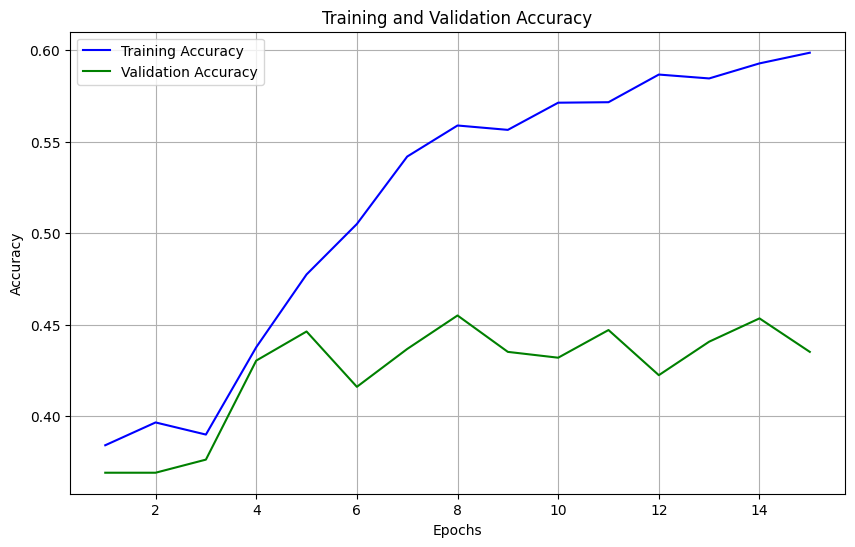

In [27]:
vocab_size = len(tokenizer.word_index) + 1

sequences1 = tokenizer.texts_to_sequences(texts1)
sequences2 = tokenizer.texts_to_sequences(texts2)

max_sequence_length = max(max(len(seq) for seq in sequences1), max(len(seq) for seq in sequences2))
sequences1 = pad_sequences(sequences1, maxlen=max_sequence_length)
sequences2 = pad_sequences(sequences2, maxlen=max_sequence_length)

# Concatenate sequences1 and sequences2 into a single input along the last axis
X = np.concatenate((sequences1, sequences2), axis=-1)
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create word embeddings (you can use Word2Vec or GloVe embeddings here)
embedding_dim = 128  # Adjust this based on the embeddings you are using
embedding_matrix = np.random.random((vocab_size, embedding_dim))

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=2 * max_sequence_length, weights=[embedding_matrix], trainable=True))
model.add(Dense(1, activation='relu'))
#model.add(Dense(1, activation='softmax'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data and validate on the validation data
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the test data
loss, final_accuracy = model.evaluate(X_test, y_test)

# Print the final test accuracy
print(f"Final Test Accuracy: {final_accuracy * 100:.4f}%")

model.summary()


import matplotlib.pyplot as plt

training_history = history.history

# Extract training and validation accuracy values
train_accuracy = training_history['accuracy']
val_accuracy = training_history['val_accuracy']

# Create a list of epoch numbers for the x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.show()





In [23]:
df.shape

(6287, 4)